In [11]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt;
#NLP
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#Other Technique
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
#CNN
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#Save & Load
import pickle
import TextNLP
from tensorflow.keras.models import model_from_json

In [2]:
def runNLP(data):
    nlpText = TextNLP.TextNLP()
    for i , _ in enumerate(data):
        data[i] = nlpText.prepareData(data[i])
        data[i] = nlpText.slang(data[i])
        data[i] = nlpText.removeStopWords(data[i])
        data[i] = nlpText.stemmAndLemmatization(data[i])
        data[i] = nlpText.removepunctuations(data[i])
    return data

In [3]:
#Loading the data set - training data.
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers','footers', 'quotes'))
twenty_test  = fetch_20newsgroups(subset='test', shuffle=True, remove=('headers','footers', 'quotes'))
# ======================= NLP ========================== 
train = runNLP(twenty_train.data)
test = runNLP(twenty_test.data)

In [4]:
def vectorizeY(y, labels):
    m = len(y)
    vec = np.zeros((m,labels))
    for i in range(len(y)):
        vec[i][y[i]] = 1
    return vec

In [5]:
class techniques:

    def naiveBayes(self,data, target):
        model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
        model = model.fit(data, target)
        return model

    def SVM(self, data, target):
        model = Pipeline([('vect',CountVectorizer()), ('tfidf', TfidfTransformer()),('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])
        model = model.fit(data, target)
        return model
    
    def LinearSVC(self, data, target):
        model = Pipeline([('vect',CountVectorizer()), ('tfidf', TfidfTransformer()),('linear-svm', LinearSVC())])
        model = model.fit(data, target)
        return model

    def RandomForest(self, data, target):
        model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-RF', RandomForestClassifier(n_estimators=100, random_state=0, max_depth=20))])
        model.fit(data, target)
        return model

    def CNN(self, data, target, testData):

        # Prepare NLP
        count_vect = CountVectorizer(stop_words='english')
        CV_train = count_vect.fit_transform(data)

        tfidf_transformer = TfidfTransformer()
        tfidf_train = tfidf_transformer.fit_transform(CV_train)
        
        testData = count_vect.transform(testData)
        testData = tfidf_transformer.transform(testData)
        
        data = tfidf_train
        target = vectorizeY(target,20)

        # Defining the model
        model = Sequential()
        model.add(Dense(1500, input_dim=data.shape[1], activation='relu'))
        model.add(Dense(20, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Model checkpoints and stoppers. Save the best weights and stops the model when no increase in performance to save time.
        esc = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
        cp = ModelCheckpoint(filepath="weights.hdf5", monitor='val_loss', verbose=1, save_best_only=True)

        # fitting the model.
        model.fit(data, target, batch_size=128, epochs=4, callbacks=[esc, cp])

        return model, testData 

In [ ]:
# ======================= Training =======================
technique = techniques()
#naiveBayes
naiveBayesModel = technique.naiveBayes(train, twenty_train.target)
#SVM
SVMModel = technique.SVM(train, twenty_train.target)
#RandomForest   
RandomForestModel = technique.RandomForest(train, twenty_train.target)
#LinearSVC
LinearSVCModel = technique.LinearSVC(train, twenty_train.target)
#CNN
CNN, test_tr = technique.CNN(train, twenty_train.target, test)

In [ ]:
# ======================= Testing =======================
predicted = LinearSVCModel.predict(test)
m = np.mean(predicted == twenty_test.target)
print(m)

In [ ]:
## Saving the models

#naiveBayesModel
with open('savedModels/naiveBayesModel', 'wb') as picklefile:
    pickle.dump(naiveBayesModel,picklefile)

#SVMModel
with open('savedModels/SVMModel', 'wb') as picklefile:
    pickle.dump(SVMModel,picklefile)

#RandomForestModel
with open('savedModels/RandomForestModel', 'wb') as picklefile:
    pickle.dump(RandomForestModel,picklefile)

#LinearSVCModel
with open('savedModels/LinearSVCModel', 'wb') as picklefile:
    pickle.dump(LinearSVCModel,picklefile)

#CNN
model_json = CNNModel.to_json()
with open("savedModels/CNN/CNNModel.json", "w") as json_file:
    json_file.write(model_json)
#Save weights
CNNModel.save_weights("savedModels/CNN/model.h5")

In [6]:
#================= Loads Models ===================
#Way to load first 4 techniques
with open('savedModels/naiveBayesModel', 'rb') as training_model:
    loaded_naive = pickle.load(training_model)

with open('savedModels/SVMModel', 'rb') as training_model:
    loaded_SVM = pickle.load(training_model)

with open('savedModels/LinearSVCModel', 'rb') as training_model:
    loaded_LinearSVC = pickle.load(training_model)

with open('savedModels/RandomForestModel', 'rb') as training_model:
    loaded_RandomForest = pickle.load(training_model)

#Load the CNN Model
json_file = open('savedModels/CNN/CNNModel.json', 'r')
loaded_model_json = json_file.read()                    #Load model structure from the json file
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("savedModels/CNN/model.h5")   # load weights into new model
#CNN_loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# ======================= Testing =======================
predicted = loaded_naive.predict(test)
NaiveAcc = np.mean(predicted == twenty_test.target)
print('naiveBayesModel :', NaiveAcc)

predicted = loaded_SVM.predict(test)
SVMAcc = np.mean(predicted == twenty_test.target)
print('SVMModel :', SVMAcc)

predicted = loaded_LinearSVC.predict(test)
SVCAcc = np.mean(predicted == twenty_test.target)
print('LinearSVCModel :', SVCAcc)

predicted = loaded_RandomForest.predict(test)
RandomAcc = np.mean(predicted == twenty_test.target)
print('RandomForestModel :', RandomAcc)

naiveBayesModel : 0.6667551779075943
SVMModel : 0.6840148698884758
LinearSVCModel : 0.694105151354222
RandomForestModel : 0.5718268720127456


In [21]:
data, target, testData = train, twenty_train.target, test

# Prepare NLP
count_vect = CountVectorizer(stop_words='english')
CV_train = count_vect.fit_transform(data)

tfidf_transformer = TfidfTransformer()
tfidf_train = tfidf_transformer.fit_transform(CV_train)
        
testData = count_vect.transform(testData)
testData = tfidf_transformer.transform(testData)

In [ ]:
##TODO

In [23]:
modifiedLabels = ['Discussions of Atheism', 'Computer Graphics','Diverse computer operating system (windows)', 
                  'Personal computer hardware systems (IBM)', 'Computer systems of Macintosh hardware',
                  'Computer windows 10', 'Diverse for-sale', 'Automobiles, automotive products and laws',
                  'Motorcycles and related products and laws', 'Discussion about baseball', 'Discussion about hockey.',
                  'Cryptography science', 'Electronic Science', 'Medicine science', 'Space Science',
                  'religion of society (Christianity)', 'Politics talk about guns', 'Politics talk about middle east',
                  'Diverse politics talks', 'Diverse religion talks']

def predict(model, text, CNN):
    if(CNN == False):
        out = model.predict(text)
    else:
        print(text.shape)
        out = model.predict(text)
        out = np.argmax(out,axis=1)
    return twenty_train.target_names[out[0]]

print('Text :', '\n',test[50],'\n')
predictedLabel = predict(loaded_LinearSVC, np.array(test[50:51]), False)
#predictedLabel = predict(loaded_model, testData[50:51].toarray(), True)
index = twenty_train.target_names.index(predictedLabel)
print('Predicted Label : ' , modifiedLabels[index])


Text : 
 oh yeah time nice spring/summer day roll window drive around looking bike bike motor opposite direction stick arm hi5'em arm feel like million buck 60km/h thing cyclist problem hi5ing cyclist always right hand lane hafta roll window hi5 back oh well think appreciate thought regard ted 

Predicted Label :  Motorcycles and related products and laws


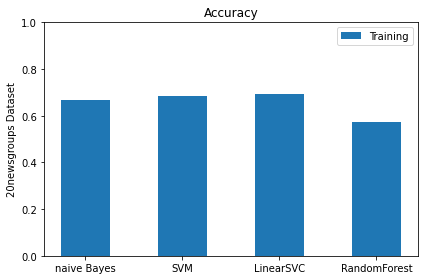

In [24]:
labels = ['naive Bayes', 'SVM', 'LinearSVC', 'RandomForest']

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0, [NaiveAcc, SVMAcc, SVCAcc, RandomAcc], width, label='Training')
#rects2 = ax.bar(x + width/2, [ourModelTestingAcc,Paper1TestingAcc,Paper2TestingAcc], width, label='Testing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.0])
ax.set_ylabel('20newsgroups Dataset')
ax.set_title('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(array1, padding=3)
#ax.bar_label(rects2, padding=3)
#ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()